In [ ]:
! pip install keras-tuner --upgrade

In [3]:
import os
import time
%matplotlib inline
print(__doc__)

import tensorflow as tf
print(tf.__version__)
# from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPool1D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
import keras_tuner as kt

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

import math, time, random, datetime
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_selection import chi2

Automatically created module for IPython interactive environment
2.15.0


In [4]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [5]:
def calculate_performace(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    acc = float(tp + tn) / test_num
    precision = float(tp) / (tp + fp)
    sensitivity = float(tp) / (tp + fn)
    specificity = float(tn) / (tn + fp)
    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    return acc, precision, sensitivity, specificity, MCC

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    xmin, xmax = plt.xlim()  # return the current xlim
    plt.xlim((xmin, xmax))  # set the xlim to xmin, xmax
    plt.ylim(xmin, xmax)  # set the xlim to xmin, xmax

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_performance(train_loss,val_loss,train_acc,val_acc):
    # plot train and validation loss across multiple runs
    plt.plot(train_loss, color='blue', label='train')
    plt.plot(val_loss, color='orange', label='validation')
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    plt.plot(train_acc, color='blue', label='train')
    plt.plot(val_acc, color='orange', label='validation')
    plt.title('model train vs validation loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
def transfer_label_from_prob(proba):
    label = [1 if val >= 0.5 else 0 for val in proba]
    return label
def plot_roc_curve(labels, probality, legend_text, auc_tag=True):
    # fpr2, tpr2, thresholds = roc_curve(labels, pred_y)
    fpr, tpr, thresholds = roc_curve(labels, probality)  # probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    if auc_tag:
        rects1 = plt.plot(fpr, tpr, label=legend_text + ' (AUC=%6.3f) ' % roc_auc)
    else:
        rects1 = plt.plot(fpr, tpr, label=legend_text)

In [6]:
# str='250516'
# def evaluate_classifiers(clfList, X_train, y_train, X_test, y_test, fea_dim, training=True, epoc=100, ep_interval=10, cutoff=0.5):
#     _accs = []
#     _aucs = []
#     _names = []
#     _specs = []
#     _sens = []
#     _mccs = []
#     _f1scores = []
#     _proba = []
#     _training_times = []
#     _histories = []  # List to store training histories

    
#     for clf in clfList:
#         try:
#             if(training):
#                 if(clf[0] == 'DNN'):
#                     print("Traning "+clf[0])
#                     callbacks = [
#                                     EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
#                                     ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
#                                     ModelCheckpoint(str+'_DNN.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
#                                 ]
#                     time_start = time.time()
#                     history = clf[1].fit(X_train, y_train, #verbose=1, 
#                                shuffle=True, epochs=epoc, 
#                               callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval=ep_interval),callbacks],
#                               batch_size=32,
#                               validation_data=(X_test, y_test))
#                     time_end = time.time()
#                     _training_times.append(time_end - time_start)
#                     _histories.append(history)  # Store the training history
#                 if(clf[0] == 'GRU'):
#                     XTrainRNN =np.array(X_train).reshape(-1, 1, fea_dim)
#                     XTestRNN = np.array(X_test).reshape(-1, 1, fea_dim)
#                     print("Traning "+clf[0])
#                     callbacks = [
#                                     EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
#                                     ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
#                                     ModelCheckpoint(str+'_GRU.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
#                                 ]
#                     time_start = time.time()
#                     history = clf[1].fit(XTrainRNN, y_train, #verbose=1, 
#                                shuffle=True, epochs=epoc, 
#                               callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval=ep_interval),callbacks],
#                               batch_size=32,
#                               validation_data=(XTestRNN, y_test))
#                     time_end = time.time()
#                     _training_times.append(time_end - time_start)
#                     _histories.append(history)  # Store the training history
#                 if(clf[0] == 'LSTM'):
#                     XTrainRNN =np.array(X_train).reshape(-1, 1, fea_dim)
#                     XTestRNN = np.array(X_test).reshape(-1, 1, fea_dim)
#                     print("Traning "+clf[0])
#                     callbacks = [
#                                     EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
#                                     ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
#                                     ModelCheckpoint(str+'_LSTM.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
#                                 ]
#                     time_start = time.time()
#                     history = clf[1].fit(XTrainRNN, y_train, #verbose=1, 
#                                shuffle=True, epochs=epoc, 
#                               callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval=ep_interval),callbacks],
#                               batch_size=32,
#                               validation_data=(XTestRNN, y_test))
#                     time_end = time.time()
#                     _training_times.append(time_end - time_start)
#                     _histories.append(history)  # Store the training history
#                 if(clf[0] == 'CNN'):
#                     XTrainCNN =np.array(X_train).reshape(-1, fea_dim, 1)
#                     XTestCNN = np.array(X_test).reshape(-1, fea_dim, 1)
#                     print("Traning "+clf[0])
#                     callbacks = [
#                                     EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
#                                     ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
#                                     ModelCheckpoint(str+'_CNN.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
#                                 ]
#                     # callbacks = [
#                     #             EarlyStopping(patience=150, monitor='val_accuracy', restore_best_weights=True),
#                     #             ReduceLROnPlateau(factor=0.25, patience=50, min_lr=1e-5),
#                     #             ModelCheckpoint(str+'_CNN.weights.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True)
#                     #         ]
#                     time_start = time.time()
#                     history = clf[1].fit(XTrainCNN, y_train, #verbose=1, 
#                                shuffle=True, epochs=epoc, 
#                               callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval=ep_interval),callbacks],
#                               batch_size=32,
#                               validation_data=(XTestCNN, y_test))
#                     time_end = time.time()
#                     _training_times.append(time_end - time_start)
#                     _histories.append(history)  # Store the training history
#                 if(clf[0] == 'CNN_LSTM'):
#                     XTrainCNN =np.array(X_train).reshape(-1, fea_dim, 1)
#                     XTestCNN = np.array(X_test).reshape(-1, fea_dim, 1)
#                     print("Traning "+clf[0])
#                     callbacks = [
#                                 EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
#                                 ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
#                                 ModelCheckpoint(str+'_CNN_LSMT.weights.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True)
#                             ]
#                     time_start = time.time()
#                     history = clf[1].fit(XTrainCNN, y_train, #verbose=1, 
#                                shuffle=True, epochs=epoc, 
#                               callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval=ep_interval),callbacks],
#                               batch_size=32,
#                               validation_data=(XTestCNN, y_test))
#                     time_end = time.time()
#                     _training_times.append(time_end - time_start)
#                     _histories.append(history)  # Store the training history
#             if(clf[0] == 'DNN'):
#                 print("Evaluating "+clf[0])
#                 proba = clf[1].predict(X_test) 
#             if(clf[0] == 'GRU' or clf[0] == 'LSTM'):
#                 print("Evaluating "+clf[0])
#                 proba = clf[1].predict(XTestRNN)
#             if(clf[0] == 'CNN'or clf[0] == 'CNN_LSTM'):
#                 print("Evaluating "+clf[0])
#                 proba = clf[1].predict(XTestCNN)
            
#         except Exception as e:
#             print("The error is: ",e)
#             continue

#         r_pred = [1 if val >= cutoff else 0 for val in proba]
#         acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
#         f1score = f1_score(y_true=y_test, y_pred=r_pred)
#         fpr, tpr, threshold = roc_curve(y_test, proba)
#         auc_clf = auc(fpr, tpr)
#         _aucs.append(auc_clf)
#         _accs.append(acc)
#         _sens.append(sens)
#         _specs.append(spec) 
#         _mccs.append(mcc)
#         _f1scores.append(f1score)
#         _names.append(clf[0])
#         _proba.append(proba)

#     scoreDataFrame = pd.DataFrame({'Model':_names, 'Accuracy': _accs, 'ROC AUC': _aucs, 'F1 Score':_f1scores,'Sens':_sens, 'Spec':_specs, 'MCC':_mccs, 'Training Time': _training_times,})
#     history_list = pd.DataFrame({'Model':_names, 'history':_histories})
#     return scoreDataFrame, _proba, history_list

In [7]:
str1='250518'
def evaluate_classifiers(clfList, X_train, y_train, X_test, y_test, fea_dim, training=True, epoc=100, ep_interval=10, cutoff=0.5):
    _accs = []
    _aucs = []
    _names = []
    _specs = []
    _sens = []
    _mccs = []
    _f1scores = []
    _proba = []
    _training_times = []
    _histories = []  # List to store training histories

    
    for clf in clfList:
        try:
            if(training):
                if(clf[0] == 'DNN'):
                    print("Traning "+clf[0])
                    callbacks = [
                                    EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                                    ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                                    ModelCheckpoint(str1+'_DNN.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                                ]
                    time_start = time.time()
                    history = clf[1].fit(X_train, y_train, #verbose=1, 
                               shuffle=True, epochs=epoc, 
                              callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=ep_interval),callbacks],
                              batch_size=32,
                              validation_data=(X_test, y_test))
                    time_end = time.time()
                    _training_times.append(time_end - time_start)
                    print("Evaluating "+clf[0])
                    proba = clf[1].predict(X_test)
                    _proba.append(proba)
                    _histories.append(history)  # Store the training history
                if(clf[0] == 'GRU'):
                    XTrainRNN =np.array(X_train).reshape(-1, 1, fea_dim)
                    XTestRNN = np.array(X_test).reshape(-1, 1, fea_dim)
                    print("Traning "+clf[0])
                    callbacks = [
                                    EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                                    ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                                    ModelCheckpoint(str1+'_GRU.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                                ]
                    time_start = time.time()
                    history = clf[1].fit(XTrainRNN, y_train, #verbose=1, 
                               shuffle=True, epochs=epoc, 
                              callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=ep_interval),callbacks],
                              batch_size=32,
                              validation_data=(XTestRNN, y_test))
                    time_end = time.time()
                    _training_times.append(time_end - time_start)
                    print("Evaluating "+clf[0])
                    proba = clf[1].predict(XTestRNN)
                    _proba.append(proba)
                    _histories.append(history)  # Store the training history
                if(clf[0] == 'LSTM'):
                    XTrainRNN =np.array(X_train).reshape(-1, 1, fea_dim)
                    XTestRNN = np.array(X_test).reshape(-1, 1, fea_dim)
                    print("Traning "+clf[0])
                    callbacks = [
                                    EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                                    ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                                    ModelCheckpoint(str1+'_LSTM.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                                ]
                    time_start = time.time()
                    history = clf[1].fit(XTrainRNN, y_train, #verbose=1, 
                               shuffle=True, epochs=epoc, 
                              callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=ep_interval),callbacks],
                              batch_size=32,
                              validation_data=(XTestRNN, y_test))
                    time_end = time.time()
                    _training_times.append(time_end - time_start)
                    print("Evaluating "+clf[0])
                    proba = clf[1].predict(XTestRNN)
                    _proba.append(proba)
                    _histories.append(history)  # Store the training history
                if(clf[0] == 'CNN'):
                    XTrainCNN =np.array(X_train).reshape(-1, fea_dim, 1)
                    XTestCNN = np.array(X_test).reshape(-1, fea_dim, 1)
                    print("Traning "+clf[0])
                    callbacks = [
                                    EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                                    ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                                    ModelCheckpoint(str1+'_CNN.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                                ]
                    # callbacks = [
                    #             EarlyStopping(patience=150, monitor='val_accuracy', restore_best_weights=True),
                    #             ReduceLROnPlateau(factor=0.25, patience=50, min_lr=1e-5),
                    #             ModelCheckpoint(str1+'_CNN.weights.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True)
                    #         ]
                    time_start = time.time()
                    history = clf[1].fit(XTrainCNN, y_train, #verbose=1, 
                               shuffle=True, epochs=epoc, 
                              callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=ep_interval),callbacks],
                              batch_size=32,
                              validation_data=(XTestCNN, y_test))
                    time_end = time.time()
                    _training_times.append(time_end - time_start)
                    print("Evaluating "+clf[0])
                    proba = clf[1].predict(XTestCNN)
                    _proba.append(proba)
                    _histories.append(history)  # Store the training history
                if(clf[0] == 'CNN_LSTM'):
                    XTrainCNN =np.array(X_train).reshape(-1, fea_dim, 1)
                    XTestCNN = np.array(X_test).reshape(-1, fea_dim, 1)
                    print("Traning "+clf[0])
                    callbacks = [
                                EarlyStopping(patience=150, monitor='val_accuracy', restore_best_weights=True),
                                ReduceLROnPlateau(factor=0.25, patience=50, min_lr=1e-5),
                                ModelCheckpoint(str1+'_CNN_LSMT.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                            ]
                    time_start = time.time()
                    history = clf[1].fit(XTrainCNN, y_train, #verbose=1, 
                               shuffle=True, epochs=epoc, 
                              callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=ep_interval),callbacks],
                              batch_size=32,
                              validation_data=(XTestCNN, y_test))
                    time_end = time.time()
                    _training_times.append(time_end - time_start)
                    print("Evaluating "+clf[0])
                    proba = clf[1].predict(XTestCNN)
                    _proba.append(proba)
                    _histories.append(history)  # Store the training history
            if(clf[0] == 'DNN'):
                print("Evaluating "+clf[0])
                proba = clf[1].predict(X_test) 
            if(clf[0] == 'GRU' or clf[0] == 'LSTM'):
                print("Evaluating "+clf[0])
                proba = clf[1].predict(XTestRNN)
            if(clf[0] == 'CNN'or clf[0] == 'CNN_LSTM'):
                print("Evaluating "+clf[0])
                proba = clf[1].predict(XTestCNN)
            
        except Exception as e:
            print("The error is: ",e)
            continue

        r_pred = [1 if val >= cutoff else 0 for val in proba]
        acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
        f1score = f1_score(y_true=y_test, y_pred=r_pred)
        fpr, tpr, threshold = roc_curve(y_test, proba)
        auc_clf = auc(fpr, tpr)
        _aucs.append(auc_clf)
        _accs.append(acc)
        _sens.append(sens)
        _specs.append(spec) 
        _mccs.append(mcc)
        _f1scores.append(f1score)
        _names.append(clf[0])
        # _proba.append(proba)

    scoreDataFrame = pd.DataFrame({'Model':_names, 'Accuracy': _accs, 'ROC AUC': _aucs, 'F1 Score':_f1scores,'Sens':_sens, 'Spec':_specs, 'MCC':_mccs, 'Training Time': _training_times,})
    history_list = pd.DataFrame({'Model':_names, 'history':_histories})
    return scoreDataFrame, _proba, history_list

In [76]:
def plot_histories(history_list):
    """
    Plots training and validation loss/accuracy for each model.

    Args:
        scoreDataFrame (pd.DataFrame): DataFrame containing model names and training histories.
    """

    for index, row in history_list.iterrows():
        model_name = row['Model']
        history = row['history']
        if model_name=='CNN_LSTM':
            continue

        if history is not None:  # Ensure history is not None
            plt.figure(figsize=(12, 5))

            # Plot training & validation accuracy values
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title(f'{model_name} Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            # Plot training & validation loss values
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title(f'{model_name} Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.tight_layout()
            plt.savefig(str1+'ACC_VS_LOSS.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"No training history available for {model_name}")



In [29]:
# Get splitted data for classical ML models
def getSplitDataSet(X, y, ratio=0.2):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    #split data into training and test data. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=123)

    return X_train, X_test, y_train, y_test, scaler

In [30]:
url_dataset ='/kaggle/input/dlm-optim-train-models/PSCV_all_new_ckh.csv' # 'Benchmark Dataset\PSCV_all_new.csv'#'hm5c_All_XGBModel.csv' # '_PSCV_Features.csv' # 'Benchmark Dataset\PSCV_desc_new.csv' #
df_main = pd.read_csv(url_dataset, header=None, dtype=float)

y = df_main.iloc[:,:1].values # df_labels[1]#
X = df_main.iloc[:,1:].values

encoder = LabelEncoder()
labels = y = encoder.fit_transform(y.ravel())


# Split the data into training and testing sets
X_train, X_test, y_train, y_test, minmax_scaler = getSplitDataSet(X, y, ratio=0.2)

fea_dim = X_train.shape[1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1059, 561) (1059,)
(265, 561) (265,)


In [36]:
def get_bad_features(pValue,thr):
    list_bad_feature=[]
    for i in range(len(pValue)):
        if pValue[i] < thr:
            list_bad_feature.append(i)
    return list_bad_feature

In [55]:
# list_bad_feature1=np.load('/kaggle/input/dlm-optim-train-models/list_bad_feature_fvs_250506.npy', allow_pickle=True)
f_score1 = chi2(X_train,y_train)
pValue1 = pd.Series(f_score1[1])
thr = 0.4 # best at thr = 0.5
list_bad_feature1 = get_bad_features(pValue1,thr)
np.save('list_bad_feature_fvs_250518.npy',list_bad_feature1)
X_train1 = np.delete(X_train, list_bad_feature1, axis=1)
X_test1 = np.delete(X_test, list_bad_feature1, axis=1)

In [56]:
fea_dim = X.shape[1]
print(X.shape)

fea_dim1 = X_train1.shape[1]
print(X_train1.shape, y_train.shape)
print(X_test1.shape, y_test.shape)

(1324, 561)
(1059, 532) (1059,)
(265, 532) (265,)


In [57]:
# Reshaping for CNN models
XTrainCNN =np.array(X_train1).reshape(-1, fea_dim1, 1)
XTestCNN = np.array(X_test1).reshape(-1, fea_dim1, 1)
# Reshaping for RNN models
XTrainRNN =np.array(X_train1).reshape(-1, 1, fea_dim1)
XTestRNN = np.array(X_test1).reshape(-1, 1, fea_dim1)

In [58]:
def build_dnn_model(hp):
    model = Sequential()
    # Hyperparameters to tune
    kernel_regularizer = regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer = kernel_regularizer))
    model.add(Dropout(rate=hp_dropout))
    
    hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
    kernel_regularizer2 = regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))
    hp_dropout2 = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dense(units=hp_units2, activation='relu', kernel_regularizer = kernel_regularizer2))
    model.add(Dropout(rate=hp_dropout2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile model with tunable loss
    loss_choice = hp.Choice('loss', ['binary_crossentropy', 'mse'])
    model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])

    
    return model

In [59]:
# /kaggle/input/dlm-optim-train-models/dlm

In [60]:
tuner = RandomSearch(
    build_dnn_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # How many models to build and fit for each trial
    directory='/kaggle/input/dlm-optim-train-models/dlm',
    project_name='dnn_tuning',
    overwrite=False
)
tuner.reload()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

_dnn = tuner.hypermodel.build(best_hps)

Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/dnn_tuning/tuner0.json
Best Hyperparameters:
l2_reg: 0.001
units: 448
dropout_rate: 0.4
learning_rate: 0.001
optimizer: adam
loss: mse


In [61]:
def build_lstm_model(hp):
    model = Sequential()
    kernel_regularizer = regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))
    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm1_units', 64, 256, step=64),
        return_sequences=True,
        activation='relu',
        dropout=hp.Float('lstm1_dropout', 0.1, 0.5, step=0.1),
        kernel_regularizer = kernel_regularizer,
        input_shape=XTrainRNN.shape[1:]
    ))

    # Second LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm2_units', 32, 128, step=32),
        return_sequences=False,
        activation='relu',
        kernel_regularizer = kernel_regularizer,
        dropout=hp.Float('lstm2_dropout', 0.1, 0.5, step=0.1)
    ))

    # Dense layer
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu', kernel_regularizer = kernel_regularizer))
    model.add(Dropout(hp.Float('dense_dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Loss function
    loss_choice = hp.Choice('loss', ['binary_crossentropy', 'mse'])

    model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])
    return model

In [62]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='/kaggle/input/dlm-optim-train-models/dlm',
    project_name='lstm_tuning',
    overwrite=False
)
tuner.reload()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

_lstm = tuner.hypermodel.build(best_hps)

Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/lstm_tuning/tuner0.json
Best Hyperparameters:
l2_reg: 0.0001
lstm1_units: 128
lstm1_dropout: 0.4
lstm2_units: 32
lstm2_dropout: 0.4
dense_units: 32
dense_dropout: 0.4
optimizer: adam
learning_rate: 0.0001
loss: binary_crossentropy


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
def build_cnn_model(hp):
    model = Sequential()
    kernel_regularizer = regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))
    # Convolutional layers
    model.add(Conv1D(filters=hp.Choice('filters', [8, 16, 32, 64]),
                     kernel_size=hp.Choice('kernel_size', [3, 5, 7, 8]),
                     activation='relu', padding='same',
                     kernel_regularizer = kernel_regularizer, 
                     input_shape=XTrainCNN.shape[1:]))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    model.add(Conv1D(filters=hp.Choice('filters2', [8, 16, 32, 64]),
                     kernel_size=hp.Choice('kernel_size2', [3, 5, 7, 8]),
                     kernel_regularizer = kernel_regularizer,
                     activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate2', 0.2, 0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', 32, 512, step=32), activation='relu', kernel_regularizer = kernel_regularizer))
    model.add(Dropout(hp.Float('final_dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile model with tunable loss
    loss_choice = hp.Choice('loss', ['binary_crossentropy', 'mse'])
    model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])
    return model

In [64]:
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/input/dlm-optim-train-models/dlm',
    project_name='cnn_tuning',
    overwrite=False
)
tuner.reload()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

_cnn = tuner.hypermodel.build(best_hps)
learning_rate = 0.001
# if optimizer_choice == 'adam':
optimizer = Adam(learning_rate=learning_rate)

# Loss function
loss_choice = 'binary_crossentropy' # 'mean_squared_error' # 'binary_crossentropy' # 'mean_absolute_error' # 'mean_squared_logarithmic_error' # 'categorical_crossentropy'

_cnn.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])

Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/cnn_tuning/tuner0.json
Best Hyperparameters:
l2_reg: 0.01
filters: 16
kernel_size: 3
dropout_rate: 0.30000000000000004
filters2: 8
kernel_size2: 7
dropout_rate2: 0.2
dense_units: 128
final_dropout: 0.2
optimizer: rmsprop
learning_rate: 0.001
loss: mse


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
learning_rate = 0.001
# if optimizer_choice == 'adam':
optimizer = Adam(learning_rate=learning_rate)

# Loss function
loss_choice = 'binary_crossentropy' # 'mean_squared_error' # 'binary_crossentropy' # 'mean_absolute_error' # 'mean_squared_logarithmic_error' # 'categorical_crossentropy'

_cnn.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])

In [66]:
def build_cnn_lstm_model(hp):
    model = Sequential()
    kernel_regularizer = regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))
    # 1D CNN Layer
    model.add(Conv1D(filters=hp.Int('cnn_filters', 32, 128, step=32),
                     kernel_size=hp.Choice('kernel_size', [3, 4, 5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = kernel_regularizer,
                     input_shape=XTrainCNN.shape[1:]))
    
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('cnn_dropout', 0.2, 0.5, step=0.1)))

    # LSTM Layer
    model.add(LSTM(units=hp.Int('lstm_units', 32, 128, step=32),
                   activation='relu',
                   return_sequences=False,
                   kernel_regularizer = kernel_regularizer,
                   dropout=hp.Float('lstm_dropout', 0.1, 0.4, step=0.1)))

    # Fully Connected Layers
    model.add(Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu', kernel_regularizer = kernel_regularizer))
    model.add(Dropout(hp.Float('dense_dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer + Learning Rate
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    if opt_choice == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif opt_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss=hp.Choice('loss', ['binary_crossentropy', 'mse']),
                  metrics=['accuracy'])
    
    return model

In [67]:
tuner = kt.RandomSearch(
    build_cnn_lstm_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='/kaggle/input/dlm-optim-train-models/dlm',
    project_name='cnn_lstm_search',
    overwrite=False
)
tuner.reload()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

_cnn_lstm = tuner.hypermodel.build(best_hps)

Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/cnn_lstm_search/tuner0.json
Best Hyperparameters:
l2_reg: 0.0001
cnn_filters: 64
kernel_size: 3
cnn_dropout: 0.30000000000000004
lstm_units: 32
lstm_dropout: 0.30000000000000004
dense_units: 64
dense_dropout: 0.4
optimizer: adam
learning_rate: 0.001
loss: binary_crossentropy


In [68]:
_Clfs = [
        ('DNN', _dnn),
        ('LSTM', _lstm),
        ('CNN', _cnn),
        ('CNN_LSTM', _cnn_lstm)
        ]

scores, proba, histories = evaluate_classifiers(_Clfs, X_train1, y_train, 
                                     X_test1, y_test, fea_dim1,
                                     training=True, 
                                     epoc=1500, ep_interval=10, cutoff=0.5)
print(scores)

Traning DNN

Epoch 1: val_accuracy improved from -inf to 0.52075, saving model to 250518_DNN.weights.h5

Epoch 2: val_accuracy did not improve from 0.52075

Epoch 3: val_accuracy did not improve from 0.52075

Epoch 4: val_accuracy did not improve from 0.52075

Epoch 5: val_accuracy did not improve from 0.52075

Epoch 6: val_accuracy improved from 0.52075 to 0.53962, saving model to 250518_DNN.weights.h5

Epoch 7: val_accuracy did not improve from 0.53962

Epoch 8: val_accuracy did not improve from 0.53962

Epoch 9: val_accuracy did not improve from 0.53962

Epoch 10: val_accuracy did not improve from 0.53962

Epoch 11: val_accuracy did not improve from 0.53962

Epoch 12: val_accuracy did not improve from 0.53962

Epoch 13: val_accuracy did not improve from 0.53962

Epoch 14: val_accuracy improved from 0.53962 to 0.55849, saving model to 250518_DNN.weights.h5

Epoch 15: val_accuracy did not improve from 0.55849

Epoch 16: val_accuracy did not improve from 0.55849

Epoch 17: val_accuracy

In [51]:
# # ('DNN', _dnn),
# # ('LSTM', _lstm),
# # ('CNN', _cnn),
# # ('CNN_LSTM', _cnn_lstm),

# proba_list = []
# proba_dnn = _dnn.predict(X_test1)
# proba_list.append(proba_dnn)

# proba_lstm = _lstm.predict(XTestRNN)
# proba_list.append(proba_lstm)

# proba_cnn = _cnn.predict(XTestCNN)
# proba_list.append(proba_cnn)

# proba_cnn_lstm = _cnn_lstm.predict(XTestCNN)
# proba_list.append(proba_cnn_lstm)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [27]:
# proba_cnn_lstm = _cnn_lstm.predict(XTestCNN)
# r_pred = [1 if val >= 0.6 else 0 for val in proba_cnn_lstm]
# acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
# f1score = f1_score(y_true=y_test, y_pred=r_pred)
# fpr, tpr, threshold = roc_curve(y_test, proba_cnn_lstm)
# auc_clf = auc(fpr, tpr)

# print("Accuracy: ", acc)
# print("Precision: ", prec)
# print("Sensitivity: ", sens)
# print("Specificity: ", spec)
# print("MCC: ", mcc)
# print("F1-Score: ", spec)
# print("AUC: ", auc_clf)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy:  0.9169811320754717
Precision:  0.9328358208955224
Sensitivity:  0.9057971014492754
Specificity:  0.9291338582677166
MCC:  0.8342648039469446
F1-Score:  0.9291338582677166
AUC:  0.9765491270112975


In [61]:
# proba_lstm = _lstm.predict(XTestRNN)
# r_pred = [1 if val >= 0.5 else 0 for val in proba_lstm]
# acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
# f1score = f1_score(y_true=y_test, y_pred=r_pred)
# fpr, tpr, threshold = roc_curve(y_test, proba_lstm)
# auc_clf = auc(fpr, tpr)

# print("Accuracy: ", acc)
# print("Precision: ", prec)
# print("Sensitivity: ", sens)
# print("Specificity: ", spec)
# print("MCC: ", mcc)
# print("F1-Score: ", spec)
# print("AUC: ", auc_clf)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy:  0.5320754716981132
Precision:  0.547945205479452
Sensitivity:  0.5797101449275363
Specificity:  0.48031496062992124
MCC:  0.060287104736362236
F1-Score:  0.48031496062992124
AUC:  0.5086157708547301


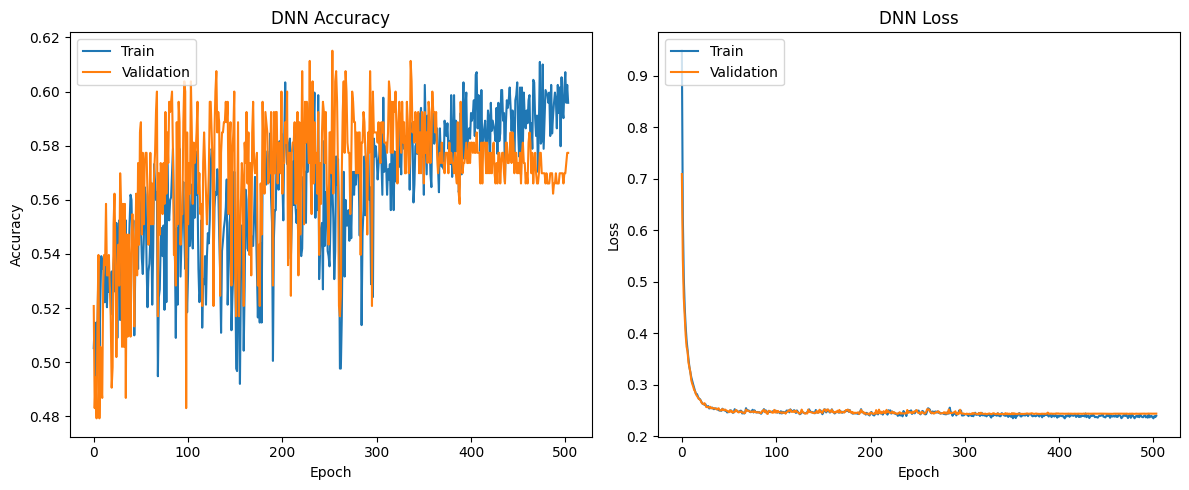

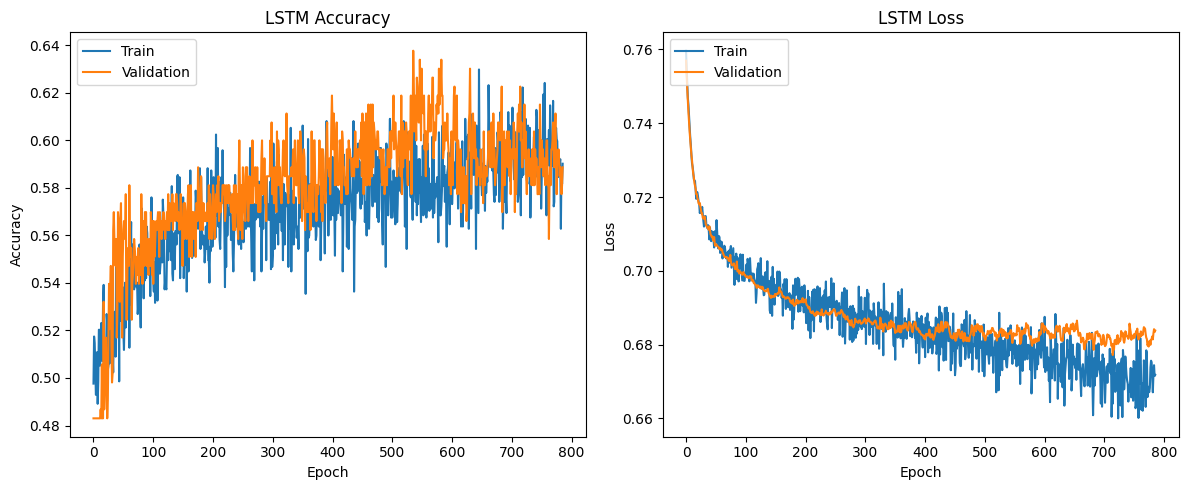

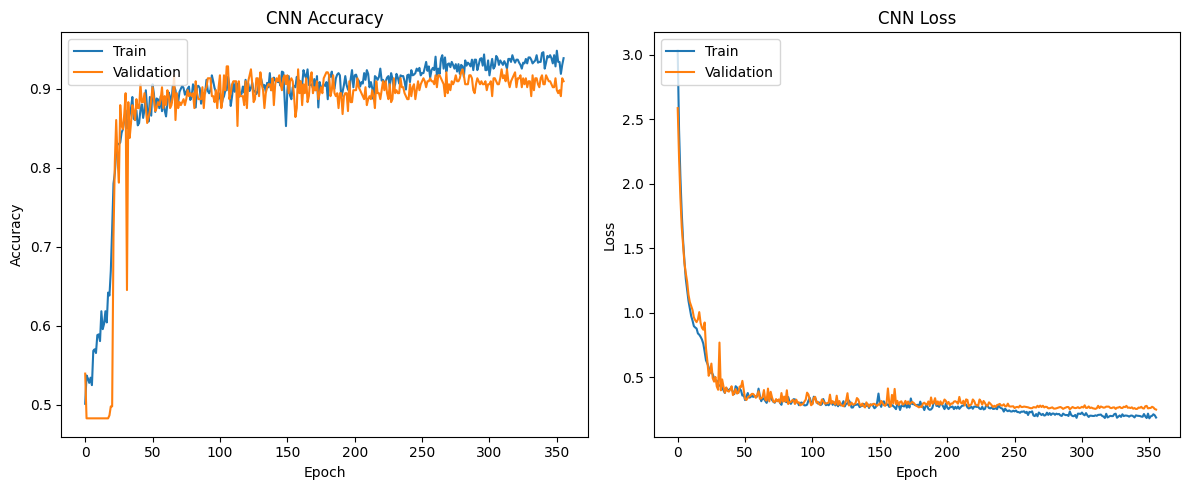

In [77]:
plot_histories(histories)

In [71]:
np.save('socres_model_names.npy',scores)
np.save('proba_models.npy',proba)
np.save('y_test.npy',y_test)
np.save('models_history.npy',histories)

In [55]:
# proba_list=np.load('/kaggle/working/proba_models.npy',allow_pickle=True)
# proba_list

Model  DNN
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.49      0.55       128
           1       0.61      0.73      0.66       137

    accuracy                           0.62       265
   macro avg       0.62      0.61      0.61       265
weighted avg       0.62      0.62      0.61       265

AUC 0.6146213503649635
------------------------------------------------------------------------------------------
Model  LSTM
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       128
           1       0.66      0.63      0.64       137

    accuracy                           0.64       265
   macro avg       0.64      0.64      0.64       265
weighted avg       0.64      0.64      0.64       265

AUC 0.6340100364963503
------------------------------------------------------------------------------------------
Model  CNN
Classification Report:
             

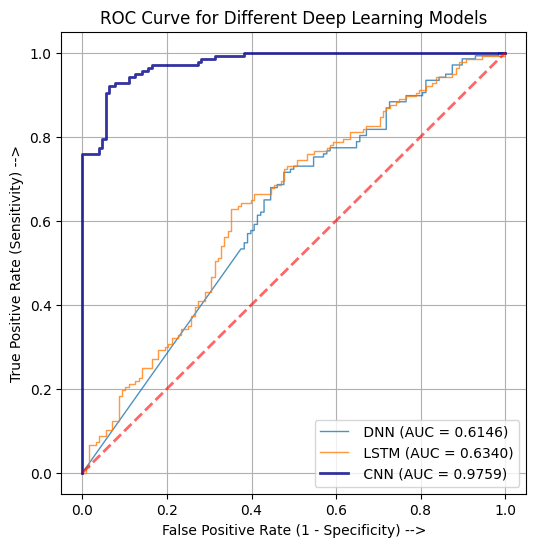

In [74]:
import matplotlib.pyplot as plt
def drawCLF_AUC(modelList, probaList, y_test):
    # size = size
    # num_cross_val = cv  
    all_performance = []
    all_labels = []
    all_prob = {}
    num_classifier = 3
    all_prob[0] = []
    all_average = []
    repeat = 5
    tprs = []
    aucs = []
    accs = []
    foldnames = []
    specs = []
    sens = []
    mccs = []
    mean_fpr = np.linspace(0, 1, 100)
#     plt.figure(figsize=(6, 6), dpi=300)
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    fig.set_dpi(100)
    fold = 0
    
    for proba, name in zip(probaList, modelList):
        print("Model ", name)
        real_labels = test_label = y_test
        _proba = proba #clf.predict(test)
        # _proba = proba.reshape(-1)
        if name=='CNN_LSTM':
            continue
            # y_pred_xgb = [1 if val >= 0.6 else 0 for val in _proba] # transfer_label_from_prob(_proba) # 
        # else:
        y_pred_xgb = [1 if val >= 0.5 else 0 for val in _proba]

        # r_pred = [1 if val >= 0.6 else 0 for val in proba]
        # print(y_test.shape, proba.shape, _proba.shape)
        # print(proba)
        # print(_proba)
        # acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
        acc, precision, sensitivity, specificity, MCC = calculate_performace(len(test_label),
                                                                                               y_pred_xgb,
                                                                                               np.array(test_label))
#         print(fold, acc, precision, sensitivity, specificity, MCC)
        # foldnames.append(fold); accs.append(acc); sens.append(sensitivity); specs.append(specificity); mccs.append(MCC)
        
    
        print('Classification Report:\n', classification_report(test_label, y_pred_xgb))
        fpr_keras, tpr_keras, _ = roc_curve(test_label, _proba)
        auc_keras = auc(fpr_keras, tpr_keras)
        print('AUC', auc_keras)
        linewdth=1
        if name=='CNN':
            linewdth=2
            ax.plot(fpr_keras, tpr_keras, color='darkblue',
                label=r' {} (AUC = %0.4f)'.format(name) % (auc_keras),
                lw=linewdth, alpha=.8)
        else:
            ax.plot(fpr_keras, tpr_keras, #color='grey',
                    label=r' {} (AUC = %0.4f)'.format(name) % (auc_keras),
                    lw=linewdth, alpha=.8)
        interp_tpr = np.interp(mean_fpr, fpr_keras, tpr_keras) 
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc_keras)

        # all_labels = all_labels + real_labels
        all_prob[0] = all_prob[0] + [val for val in _proba]  
        all_performance.append([acc, precision, sensitivity, specificity, MCC])
        print('---' * 30)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.6) # label='Mid Point', 

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    # ax.plot(mean_fpr, mean_tpr, color='b',
    #         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
    #         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                 label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic curve (ROC-Curve)")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate (1 - Specificity) -->')
    plt.ylabel('True Positive Rate (Sensitivity) -->')
    plt.grid()
    
    # plt.axes
    plt.title('ROC Curve for Different Deep Learning Models')
    plt.savefig('ROC_Curve.png', dpi=300, bbox_inches='tight')
    plt.show()

drawCLF_AUC(scores['Model'], proba, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.49      0.55       128
           1       0.61      0.73      0.66       137

    accuracy                           0.62       265
   macro avg       0.62      0.61      0.61       265
weighted avg       0.62      0.62      0.61       265

mAP 0.5926486872735599
------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       128
           1       0.66      0.63      0.64       137

    accuracy                           0.64       265
   macro avg       0.64      0.64      0.64       265
weighted avg       0.64      0.64      0.64       265

mAP 0.6200132049605556
------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   

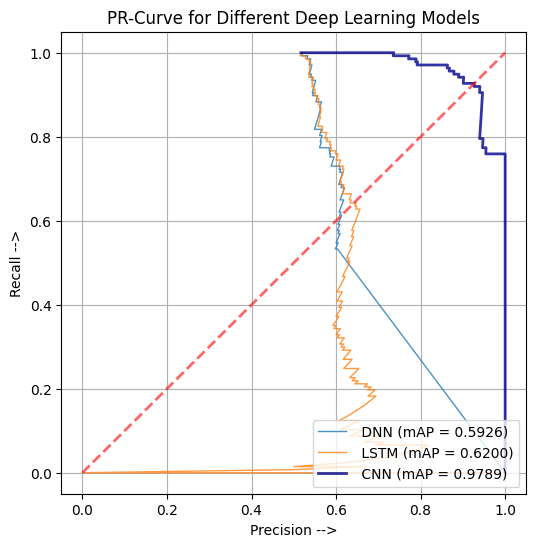

In [78]:
import matplotlib.pyplot as plt
def drawCLF_PRCurve(modelList, probaList, y_test):
    # size = size
    # num_cross_val = cv  
    all_performance = []
    all_labels = []
    all_prob = {}
    num_classifier = 3
    all_prob[0] = []
    all_average = []
    repeat = 5
    tprs = []
    aucs = []
    accs = []
    foldnames = []
    specs = []
    sens = []
    mccs = []
    mean_fpr = np.linspace(0, 1, 100)
#     plt.figure(figsize=(6, 6), dpi=300)
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    fig.set_dpi(100)
    fold = 0
    
    for proba, name in zip(probaList, modelList):

        real_labels = test_label = y_test
        _proba = proba #clf.predict(test)
        if name=='CNN_LSTM':
            continue
            # y_pred = [1 if val >= 0.6 else 0 for val in _proba] # transfer_label_from_prob(_proba) # 
        # else:
        y_pred = [1 if val >= 0.5 else 0 for val in _proba]
        # y_pred = [1 if val >= 0.5 else 0 for val in _proba] # transfer_label_from_prob(_proba) # 

        acc, precision, sensitivity, specificity, MCC = calculate_performace(len(test_label),
                                                                                               y_pred,
                                                                                               np.array(test_label))
#         print(fold, acc, precision, sensitivity, specificity, MCC)
        # foldnames.append(fold); accs.append(acc); sens.append(sensitivity); specs.append(specificity); mccs.append(MCC)
        
    
        print('Classification Report:\n', classification_report(test_label, y_pred))
        pre_keras, rec_keras, _ = precision_recall_curve(test_label, _proba)
        auc_keras = average_precision_score(test_label, _proba)
        print('mAP', auc_keras)
        linewdth=1
        if name=='CNN':
            linewdth=2
            ax.plot(pre_keras, rec_keras, color='darkblue',
                label=r' {} (mAP = %0.4f)'.format(name) % (auc_keras),
                lw=linewdth, alpha=.8)
        else:
            ax.plot(pre_keras, rec_keras, #color='grey',
                label=r' {} (mAP = %0.4f)'.format(name) % (auc_keras),
                lw=linewdth, alpha=.8)
        
        interp_tpr = np.interp(mean_fpr, pre_keras, rec_keras) 
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc_keras)

        # all_labels = all_labels + real_labels
        all_prob[0] = all_prob[0] + [val for val in _proba]  
        all_performance.append([acc, precision, sensitivity, specificity, MCC])
        print('---' * 30)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.6) # label='Mid Point', 

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    # ax.plot(mean_fpr, mean_tpr, color='b',
    #         label=r'Mean mAp (mAP = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
    #         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                 label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Precision-Recall curve (PR-Curve)")
    ax.legend(loc="lower right")
    plt.xlabel('Precision -->')
    plt.ylabel('Recall -->')
    plt.grid()
    plt.title('PR-Curve for Different Deep Learning Models')
    plt.savefig('PR_Curve.png', dpi=300, bbox_inches='tight')
    # plt.axes
    plt.show()

drawCLF_PRCurve(scores['Model'], proba, y_test)

In [82]:
def get_final_model():
    tuner = kt.RandomSearch(
        build_cnn_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='/kaggle/input/dlm-optim-train-models/dlm',
        project_name='cnn_tuning',
        overwrite=False
    )
    
    tuner.reload()
    best_hps = tuner.get_best_hyperparameters(1)[0]
    
    _cnn = tuner.hypermodel.build(best_hps)
    learning_rate = 0.001
    # if optimizer_choice == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
    
    # Loss function
    loss_choice = 'binary_crossentropy' # 'mean_squared_error' # 'binary_crossentropy' # 'mean_absolute_error' # 'mean_squared_logarithmic_error' # 'categorical_crossentropy'
    
    _cnn.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])
    return _cnn


def hm5c_deepCnnClassifier(cv=10):
    
    num_cross_val = cv  
    all_performance = []
    all_labels = []
    all_prob = {}
    num_classifier = 3
    all_prob[0] = []
    all_average = []
    repeat = 5
    tprs = []
    aucs = []
    accs = []
    foldnames = []
    specs = []
    sens = []
    mccs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # y = df_main.iloc[:,:1].values # df_labels[1]#
    df = df_main.sample(frac=1, random_state=42)
    X = df.iloc[:,1:].values
    y = df.iloc[:,:1].values

    encoder = LabelEncoder()
    y = encoder.fit_transform(y.ravel())
    # Randomly sample a fraction of rows
    # X = X.sample(frac=1, random_state=42)
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    XT = np.delete(X, list_bad_feature1, axis=1)
    yT = y
    print(XT.shape, y.shape)
    _fea_dim = XT.shape[1]
    fold = 0
    
    cv = StratifiedKFold(n_splits=cv)
    for i, (train_index, test_index) in enumerate(cv.split(XT, yT)):

        print("Fold ", i)
        train, train_label = XT[train_index], yT[train_index]
        test, test_label = XT[test_index], yT[test_index]

        real_labels = []
        for val in test_label:
            if val == 1:
                real_labels.append(1)
            else:
                real_labels.append(0)

        
        clf = get_final_model()
        XTrainCNN =np.array(train).reshape(-1, _fea_dim, 1)
        XTestCNN = np.array(test).reshape(-1, _fea_dim, 1)
        # print("Traning "+clf[0])
        callbacks = [
                        EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                        ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                        ModelCheckpoint('{0}_CNN_LSMT.weights.h5'.format(fold), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
                    ]
        clf.fit(XTrainCNN, train_label, #verbose=1, 
                    shuffle=True, epochs=1000, 
                    callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
                    batch_size=32,
                    validation_data=(XTestCNN, test_label))
        
        _proba = clf.predict(test)
        y_pred = [1 if val >= 0.5 else 0 for val in _proba] # 

        acc, precision, sensitivity, specificity, MCC = calculate_performace(len(test_label),
                                                                                               y_pred,
                                                                                               np.array(test_label))
#         print(fold, acc, precision, sensitivity, specificity, MCC)
        foldnames.append(fold); accs.append(acc); sens.append(sensitivity); specs.append(specificity); mccs.append(MCC)
        
    
        print('Classification Report:\n', classification_report(test_label, y_pred))
        fpr_keras, tpr_keras, _ = roc_curve(test_label, _proba)
        auc_keras = auc(fpr_keras, tpr_keras)
        print('AUC', auc_keras)
       
        ax.plot(fpr_keras, tpr_keras, #color='grey',
                label=r'ROC fold {} (AUC = %0.4f)'.format(fold) % (auc_keras),
                lw=1, alpha=.6)
        interp_tpr = np.interp(mean_fpr, fpr_keras, tpr_keras) 
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc_keras)

        all_labels = all_labels + real_labels
        all_prob[0] = all_prob[0] + [val for val in _proba]  
        all_performance.append([acc, precision, sensitivity, specificity, MCC])
        print('---' * 30)
        fold += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.6) # label='Mid Point', 

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC-Curve ({0}-fold Cross Validation)".format(cv))
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate (1 - Specificity) -->')
    plt.ylabel('True Positive Rate (Sensitivity) -->')
    plt.grid()
    plt.title('ROC-Curve ({0}-fold Cross Validation)'.format(cv))
    plt.savefig('{0}_ROC_Curve.png'.format(cv), dpi=300, bbox_inches='tight')
    # plt.axes
    plt.show()

    mean_performance = np.mean(np.array(all_performance), axis=0)
    meanACC, meanSens, meanSpec, meanMCC, meanAUC = mean_performance[0], mean_performance[2], mean_performance[3], mean_performance[4], mean_auc

    meanScore = pd.DataFrame({'Mean ACC': meanACC, 'Mean Sens': meanSens, 'Mean Spec': meanSpec,
                              'Mean MCC': meanMCC, 'Mean AUC': meanAUC}, index=[0])
    print('---' * 50)
    foldScore = pd.DataFrame({'ACC': accs, 'Sen':sens, 'Spec':specs, 'MCC':mccs, 'AUC': aucs})

    np.save("kfold_socre.npy",foldScore)
    return foldScore, meanScore

(1324, 532) (1324,)
Fold  0
Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/cnn_tuning/tuner0.json


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50376, saving model to 0_CNN_LSMT.weights.h5

Epoch 2: val_accuracy improved from 0.50376 to 0.55639, saving model to 0_CNN_LSMT.weights.h5

Epoch 3: val_accuracy did not improve from 0.55639

Epoch 4: val_accuracy did not improve from 0.55639

Epoch 5: val_accuracy did not improve from 0.55639

Epoch 6: val_accuracy did not improve from 0.55639

Epoch 7: val_accuracy did not improve from 0.55639

Epoch 8: val_accuracy did not improve from 0.55639

Epoch 9: val_accuracy did not improve from 0.55639

Epoch 10: val_accuracy did not improve from 0.55639

Epoch 11: val_accuracy did not improve from 0.55639

Epoch 12: val_accuracy did not improve from 0.55639

Epoch 13: val_accuracy did not improve from 0.55639

Epoch 14: val_accuracy did not improve from 0.55639

Epoch 15: val_accuracy did not improve from 0.55639

Epoch 16: val_accuracy did not improve from 0.55639

Epoch 17: val_accuracy did not improve from 0.55639

Epoch 18: val_accuracy d

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.48120, saving model to 1_CNN_LSMT.weights.h5

Epoch 2: val_accuracy improved from 0.48120 to 0.49624, saving model to 1_CNN_LSMT.weights.h5

Epoch 3: val_accuracy did not improve from 0.49624

Epoch 4: val_accuracy did not improve from 0.49624

Epoch 5: val_accuracy did not improve from 0.49624

Epoch 6: val_accuracy did not improve from 0.49624

Epoch 7: val_accuracy did not improve from 0.49624

Epoch 8: val_accuracy did not improve from 0.49624

Epoch 9: val_accuracy did not improve from 0.49624

Epoch 10: val_accuracy did not improve from 0.49624

Epoch 11: val_accuracy did not improve from 0.49624

Epoch 12: val_accuracy did not improve from 0.49624

Epoch 13: val_accuracy did not improve from 0.49624

Epoch 14: val_accuracy improved from 0.49624 to 0.51128, saving model to 1_CNN_LSMT.weights.h5

Epoch 15: val_accuracy improved from 0.51128 to 0.51880, saving model to 1_CNN_LSMT.weights.h5

Epoch 16: val_accuracy improved from 0.51880

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50376, saving model to 2_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.50376

Epoch 3: val_accuracy did not improve from 0.50376

Epoch 4: val_accuracy did not improve from 0.50376

Epoch 5: val_accuracy did not improve from 0.50376

Epoch 6: val_accuracy did not improve from 0.50376

Epoch 7: val_accuracy did not improve from 0.50376

Epoch 8: val_accuracy did not improve from 0.50376

Epoch 9: val_accuracy did not improve from 0.50376

Epoch 10: val_accuracy did not improve from 0.50376

Epoch 11: val_accuracy did not improve from 0.50376

Epoch 12: val_accuracy did not improve from 0.50376

Epoch 13: val_accuracy did not improve from 0.50376

Epoch 14: val_accuracy did not improve from 0.50376

Epoch 15: val_accuracy improved from 0.50376 to 0.57143, saving model to 2_CNN_LSMT.weights.h5

Epoch 16: val_accuracy did not improve from 0.57143

Epoch 17: val_accuracy did not improve from 0.57143

Epoch 18: val_accuracy d

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50376, saving model to 3_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.50376

Epoch 3: val_accuracy did not improve from 0.50376

Epoch 4: val_accuracy did not improve from 0.50376

Epoch 5: val_accuracy did not improve from 0.50376

Epoch 6: val_accuracy did not improve from 0.50376

Epoch 7: val_accuracy did not improve from 0.50376

Epoch 8: val_accuracy did not improve from 0.50376

Epoch 9: val_accuracy did not improve from 0.50376

Epoch 10: val_accuracy did not improve from 0.50376

Epoch 11: val_accuracy did not improve from 0.50376

Epoch 12: val_accuracy did not improve from 0.50376

Epoch 13: val_accuracy did not improve from 0.50376

Epoch 14: val_accuracy did not improve from 0.50376

Epoch 15: val_accuracy did not improve from 0.50376

Epoch 16: val_accuracy did not improve from 0.50376

Epoch 17: val_accuracy did not improve from 0.50376

Epoch 18: val_accuracy improved from 0.50376 to 0.51880, saving mod

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.53788, saving model to 4_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.53788

Epoch 3: val_accuracy did not improve from 0.53788

Epoch 4: val_accuracy did not improve from 0.53788

Epoch 5: val_accuracy did not improve from 0.53788

Epoch 6: val_accuracy did not improve from 0.53788

Epoch 7: val_accuracy did not improve from 0.53788

Epoch 8: val_accuracy did not improve from 0.53788

Epoch 9: val_accuracy did not improve from 0.53788

Epoch 10: val_accuracy did not improve from 0.53788

Epoch 11: val_accuracy did not improve from 0.53788

Epoch 12: val_accuracy did not improve from 0.53788

Epoch 13: val_accuracy did not improve from 0.53788

Epoch 14: val_accuracy did not improve from 0.53788

Epoch 15: val_accuracy did not improve from 0.53788

Epoch 16: val_accuracy did not improve from 0.53788

Epoch 17: val_accuracy did not improve from 0.53788

Epoch 18: val_accuracy improved from 0.53788 to 0.55303, saving mod

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to 5_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: val_accuracy did not improve from 0.50000

Epoch 6: val_accuracy did not improve from 0.50000

Epoch 7: val_accuracy did not improve from 0.50000

Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: val_accuracy did not improve from 0.50000

Epoch 10: val_accuracy did not improve from 0.50000

Epoch 11: val_accuracy did not improve from 0.50000

Epoch 12: val_accuracy did not improve from 0.50000

Epoch 13: val_accuracy did not improve from 0.50000

Epoch 14: val_accuracy did not improve from 0.50000

Epoch 15: val_accuracy did not improve from 0.50000

Epoch 16: val_accuracy did not improve from 0.50000

Epoch 17: val_accuracy did not improve from 0.50000

Epoch 18: val_accuracy improved from 0.50000 to 0.50758, saving mod

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.48485, saving model to 6_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.48485

Epoch 3: val_accuracy improved from 0.48485 to 0.50758, saving model to 6_CNN_LSMT.weights.h5

Epoch 4: val_accuracy did not improve from 0.50758

Epoch 5: val_accuracy did not improve from 0.50758

Epoch 6: val_accuracy did not improve from 0.50758

Epoch 7: val_accuracy did not improve from 0.50758

Epoch 8: val_accuracy did not improve from 0.50758

Epoch 9: val_accuracy did not improve from 0.50758

Epoch 10: val_accuracy did not improve from 0.50758

Epoch 11: val_accuracy did not improve from 0.50758

Epoch 12: val_accuracy did not improve from 0.50758

Epoch 13: val_accuracy did not improve from 0.50758

Epoch 14: val_accuracy did not improve from 0.50758

Epoch 15: val_accuracy did not improve from 0.50758

Epoch 16: val_accuracy did not improve from 0.50758

Epoch 17: val_accuracy improved from 0.50758 to 0.54545, saving model to 6_CN

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.56061, saving model to 7_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.56061

Epoch 3: val_accuracy did not improve from 0.56061

Epoch 4: val_accuracy did not improve from 0.56061

Epoch 5: val_accuracy did not improve from 0.56061

Epoch 6: val_accuracy did not improve from 0.56061

Epoch 7: val_accuracy did not improve from 0.56061

Epoch 8: val_accuracy improved from 0.56061 to 0.57576, saving model to 7_CNN_LSMT.weights.h5

Epoch 9: val_accuracy did not improve from 0.57576

Epoch 10: val_accuracy did not improve from 0.57576

Epoch 11: val_accuracy did not improve from 0.57576

Epoch 12: val_accuracy did not improve from 0.57576

Epoch 13: val_accuracy did not improve from 0.57576

Epoch 14: val_accuracy did not improve from 0.57576

Epoch 15: val_accuracy did not improve from 0.57576

Epoch 16: val_accuracy did not improve from 0.57576

Epoch 17: val_accuracy did not improve from 0.57576

Epoch 18: val_accuracy d

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to 8_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: val_accuracy did not improve from 0.50000

Epoch 6: val_accuracy did not improve from 0.50000

Epoch 7: val_accuracy did not improve from 0.50000

Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: val_accuracy did not improve from 0.50000

Epoch 10: val_accuracy did not improve from 0.50000

Epoch 11: val_accuracy did not improve from 0.50000

Epoch 12: val_accuracy improved from 0.50000 to 0.50758, saving model to 8_CNN_LSMT.weights.h5

Epoch 13: val_accuracy did not improve from 0.50758

Epoch 14: val_accuracy improved from 0.50758 to 0.52273, saving model to 8_CNN_LSMT.weights.h5

Epoch 15: val_accuracy did not improve from 0.52273

Epoch 16: val_accuracy did not improve from 0.52273

Epoch 17: val_accuracy did not imp

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to 9_CNN_LSMT.weights.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: val_accuracy did not improve from 0.50000

Epoch 6: val_accuracy did not improve from 0.50000

Epoch 7: val_accuracy did not improve from 0.50000

Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: val_accuracy did not improve from 0.50000

Epoch 10: val_accuracy did not improve from 0.50000

Epoch 11: val_accuracy did not improve from 0.50000

Epoch 12: val_accuracy did not improve from 0.50000

Epoch 13: val_accuracy did not improve from 0.50000

Epoch 14: val_accuracy did not improve from 0.50000

Epoch 15: val_accuracy did not improve from 0.50000

Epoch 16: val_accuracy improved from 0.50000 to 0.52273, saving model to 9_CNN_LSMT.weights.h5

Epoch 17: val_accuracy did not improve from 0.52273

Epoch 18: val_accuracy d

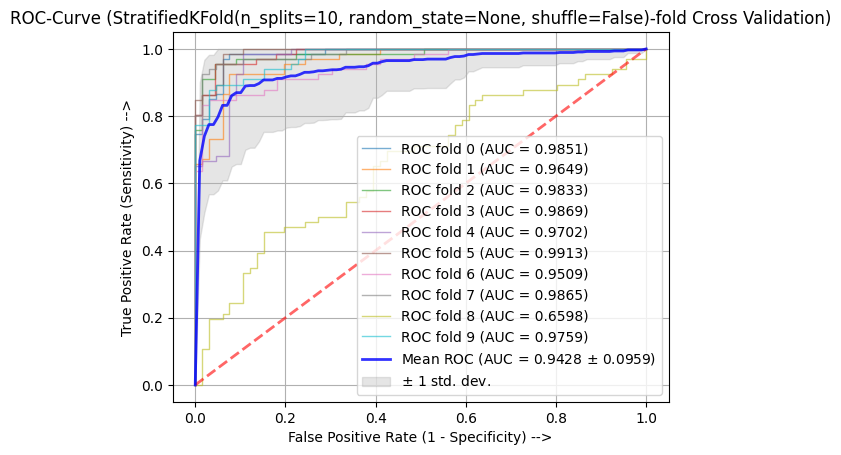

------------------------------------------------------------------------------------------------------------------------------------------------------


In [83]:
foldScore_XGB, meanScore_XGB = hm5c_deepCnnClassifier(cv=10)

In [84]:
foldScore_XGB

,ACC,Sen,Spec,MCC,AUC
0,0.954887,0.970149,0.939394,0.910161,0.985075
1,0.924812,0.925373,0.924242,0.849616,0.964948
2,0.947368,0.909091,0.985075,0.897214,0.983265
3,0.947368,0.939394,0.955224,0.894820,0.986884
4,0.939394,0.984848,0.893939,0.882442,0.970156
5,0.962121,0.984848,0.939394,0.925199,0.991276
6,0.909091,0.833333,0.984848,0.827738,0.950872
7,0.954545,0.954545,0.954545,0.909091,0.986455
8,0.636364,0.469697,0.803030,0.289271,0.659780
9,0.916667,0.878788,0.954545,0.835735,0.975895


In [85]:
 meanScore_XGB

,Mean ACC,Mean Sens,Mean Spec,Mean MCC,Mean AUC
0,0.909262,0.885007,0.933424,0.822129,0.942783


In [93]:
tuner = kt.RandomSearch(
        build_cnn_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='/kaggle/input/dlm-optim-train-models/dlm',
        project_name='cnn_tuning',
        overwrite=False
    )
    
tuner.reload()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Reloading Tuner from /kaggle/input/dlm-optim-train-models/dlm/cnn_tuning/tuner0.json
Best Hyperparameters:
l2_reg: 0.01
filters: 16
kernel_size: 3
dropout_rate: 0.30000000000000004
filters2: 8
kernel_size2: 7
dropout_rate2: 0.2
dense_units: 128
final_dropout: 0.2
optimizer: rmsprop
learning_rate: 0.001
loss: mse


In [96]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
def build_cnn(input_shape):
    model = Sequential()
    kernel_regularizer = regularizers.l2(0.01)
    # Convolutional layers
    
    # shape=input_shape
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=16,
                     kernel_size=3,
                     activation='relu', padding='same',
                     kernel_regularizer = kernel_regularizer                     
                    ))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.30000000000000004))

    model.add(Conv1D(filters=8,
                     kernel_size=7,
                     kernel_regularizer = kernel_regularizer,
                     activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu', kernel_regularizer = kernel_regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    learning_rate = 0.001
    # if optimizer_choice == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
    
    # Loss function
    loss_choice = 'binary_crossentropy' # 'mean_squared_error' # 'binary_crossentropy' # 'mean_absolute_error' # 'mean_squared_logarithmic_error' # 'categorical_crossentropy'
    
    model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])
    # model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])
    return model

In [103]:
XTrainCNN =np.array(X_train1).reshape(-1, X_train1.shape[1], 1)
XTestCNN = np.array(X_test1).reshape(-1, X_train1.shape[1], 1)
# print("Traning "+clf[0])
callbacks = [
                EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                ModelCheckpoint('{0}_CNN.weights.h5'.format('fv'), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
            ]
input_shape=XTrainCNN.shape[1:]
clf=build_cnn(input_shape)
clf.fit(XTrainCNN, y_train, #verbose=1, 
            shuffle=True, epochs=1000, 
            callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
            batch_size=32,
            validation_data=(XTestCNN, y_test))


Epoch 1: val_accuracy improved from -inf to 0.48302, saving model to fv_CNN.weights.h5

Epoch 2: val_accuracy did not improve from 0.48302

Epoch 3: val_accuracy did not improve from 0.48302

Epoch 4: val_accuracy did not improve from 0.48302

Epoch 5: val_accuracy did not improve from 0.48302

Epoch 6: val_accuracy did not improve from 0.48302

Epoch 7: val_accuracy did not improve from 0.48302

Epoch 8: val_accuracy did not improve from 0.48302

Epoch 9: val_accuracy did not improve from 0.48302

Epoch 10: val_accuracy did not improve from 0.48302

Epoch 11: val_accuracy did not improve from 0.48302

Epoch 12: val_accuracy did not improve from 0.48302

Epoch 13: val_accuracy did not improve from 0.48302

Epoch 14: val_accuracy did not improve from 0.48302

Epoch 15: val_accuracy improved from 0.48302 to 0.48679, saving model to fv_CNN.weights.h5

Epoch 16: val_accuracy improved from 0.48679 to 0.49434, saving model to fv_CNN.weights.h5

Epoch 17: val_accuracy did not improve from 0.

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


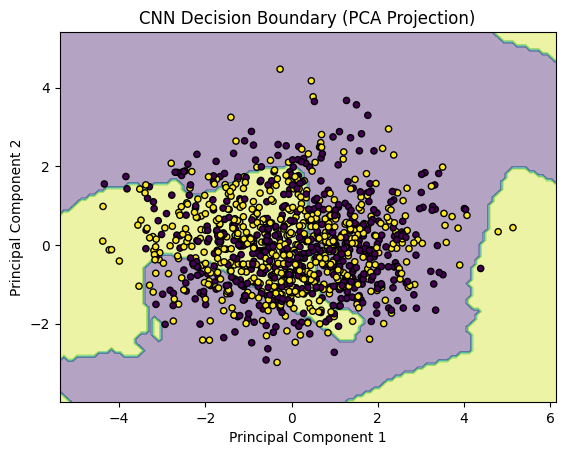

In [106]:
from sklearn.decomposition import PCA
# 1. Reduce Dimensionality with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train1)  # Use X_train1, not XTrainCNN
X_test_pca = pca.transform(X_test1)      # Use X_test1

# 2. Create Grid to Evaluate Model
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
grid_points_cnn_input = grid_points_original_space.reshape(-1, X_train1.shape[1], 1)  # Reshape for CNN

# 3. Get Predictions from Model
Z = clf.predict(grid_points_cnn_input)
Z = (Z > 0.5).astype(int)  # Threshold to get binary predictions
Z = Z.reshape(xx.shape)

# 4. Plot Decision Boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
plt.title('CNN Decision Boundary (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.savefig('CNN Decision Boundary (PCA Projection).png', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
# # Imports
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import matplotlib.pyplot as plt
# 1. Create a feature extractor model (up to the second last layer)
# Reshape the input data to be 3D for CNN
XTrainCNN = np.array(X_train1).reshape(-1, X_train1.shape[1], 1)
XTestCNN = np.array(X_test1).reshape(-1, X_test1.shape[1], 1)


input_shape = XTrainCNN.shape[1:]  # Get input shape from reshaped data

kernel_regularizer = regularizers.l2(0.01)
enh_inp1=Input(input_shape)

# enh_inp6 = Input((1,8000))

enh_x1= Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(enh_inp1)
enh_x1= MaxPool1D(pool_size=2)(enh_x1)
enh_x1=BatchNormalization()(enh_x1)
enh_x1 = Dropout(0.30000000000000004)(enh_x1)

enh_x1= Conv1D(filters=8, kernel_size=7, activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(enh_x1)
enh_x1= MaxPool1D(pool_size=2)(enh_x1)
enh_x1=BatchNormalization()(enh_x1)
enh_x1 = Dropout(0.2)(enh_x1)
    
x= Flatten()(enh_x1)

x = Dense(units=128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(0.2)(x)

x = Dense(1,activation='sigmoid')(x)
model= Model(inputs=[enh_inp1],outputs=x)

# print (model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_choice = 'binary_crossentropy'
model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])

callbacks = [
                EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                ModelCheckpoint('{0}_CNN.weights.h5'.format('fv'), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
            ]

# Train the CNN model
# model.fit(XTrainCNN, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(XTestCNN, y_test)) # reduced epochs, added validation data
model.fit(XTrainCNN, y_train, #verbose=1, 
            shuffle=True, epochs=1000, 
            callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
            batch_size=32,
            validation_data=(XTestCNN, y_test))


Epoch 1: val_accuracy improved from -inf to 0.57736, saving model to fv_CNN.weights.h5

Epoch 2: val_accuracy did not improve from 0.57736

Epoch 3: val_accuracy did not improve from 0.57736

Epoch 4: val_accuracy did not improve from 0.57736

Epoch 5: val_accuracy did not improve from 0.57736

Epoch 6: val_accuracy did not improve from 0.57736

Epoch 7: val_accuracy did not improve from 0.57736

Epoch 8: val_accuracy did not improve from 0.57736

Epoch 9: val_accuracy did not improve from 0.57736

Epoch 10: val_accuracy did not improve from 0.57736

Epoch 11: val_accuracy did not improve from 0.57736

Epoch 12: val_accuracy did not improve from 0.57736

Epoch 13: val_accuracy did not improve from 0.57736

Epoch 14: val_accuracy did not improve from 0.57736

Epoch 15: val_accuracy did not improve from 0.57736

Epoch 16: val_accuracy did not improve from 0.57736

Epoch 17: val_accuracy did not improve from 0.57736

Epoch 18: val_accuracy did not improve from 0.57736

Epoch 19: val_accu

In [126]:
model.layers[-2].output

<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1660>

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


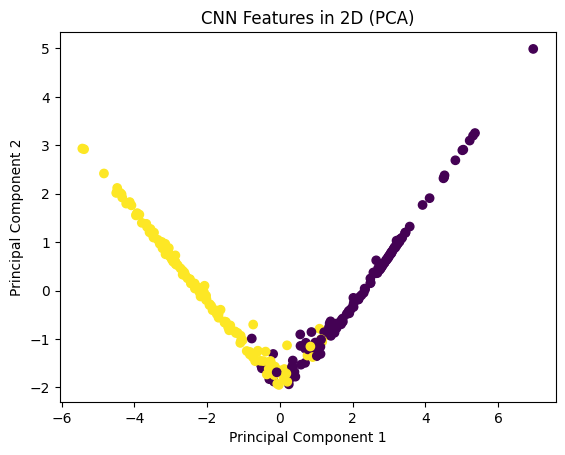

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


Test results - Loss: 0.18567143380641937 - Accuracy: 93.20755004882812%
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


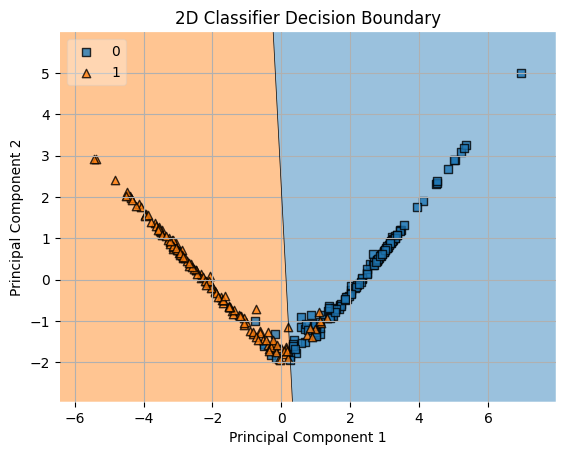

In [131]:
# 1. Create a feature extractor model (up to the second last layer)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output) #changed keras to tf.keras
features = feature_extractor.predict(XTestCNN)

# 3. Reduce to 2D using PCA
pca = PCA(n_components=2)
X_testing_pca = pca.fit_transform(features)  # Use the features extracted from CNN

# Generate scatter plot for training data
plt.scatter(X_testing_pca[:,0], X_testing_pca[:,1], c=y_test) #added c=Targets_testing
plt.title('CNN Features in 2D (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



# Define a simple 2D model for visualization
model_2d = Sequential([
    Dense(1, activation='sigmoid')
])
model_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary data

callbacks = [
                EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                ModelCheckpoint('{0}_CNN.weights.h5'.format('fv'), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
            ]

# # Train the CNN model
# # model.fit(XTrainCNN, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(XTestCNN, y_test)) # reduced epochs, added validation data
# model.fit(XTrainCNN, y_train, #verbose=1, 
#             shuffle=True, epochs=1000, 
#             callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
#             batch_size=32,
#             validation_data=(XTestCNN, y_test))

# 4. Train a simple classifier on 2D space
model_2d.fit(X_testing_pca, y_test, epochs=1000, batch_size=32, verbose=1, callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],) # Train on PCA output


# Test the model after training
test_results = model_2d.evaluate(X_testing_pca, y_test, verbose=0) # Evaluate the 2D model
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

# Plot decision boundary
plot_decision_regions(X_testing_pca, y_test, clf=model_2d, legend=2) # Use the 2D model for plotting
plt.title('2D Classifier Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.savefig('Decision Boundary (PCA Projection).png', dpi=300, bbox_inches='tight')
plt.show()

In [148]:
# # Imports
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import matplotlib.pyplot as plt
# 1. Create a feature extractor model (up to the second last layer)
# Reshape the input data to be 3D for CNN
XTrainCNN = np.array(X_train1).reshape(-1, X_train1.shape[1], 1)
XTestCNN = np.array(X_test1).reshape(-1, X_test1.shape[1], 1)


input_shape = XTrainCNN.shape[1:]  # Get input shape from reshaped data

kernel_regularizer = regularizers.l2(0.01)
enh_inp1=Input(input_shape)

# enh_inp6 = Input((1,8000))

enh_x1= Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(enh_inp1)
enh_x1= MaxPool1D(pool_size=2)(enh_x1)
enh_x1=BatchNormalization()(enh_x1)
enh_x1 = Dropout(0.30000000000000004)(enh_x1)

enh_x1= Conv1D(filters=8, kernel_size=7, activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(enh_x1)
enh_x1= MaxPool1D(pool_size=2)(enh_x1)
enh_x1=BatchNormalization()(enh_x1)
enh_x1 = Dropout(0.2)(enh_x1)
    
x= Flatten()(enh_x1)

x = Dense(units=128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(0.2)(x)

x = Dense(1,activation='sigmoid')(x)
model= Model(inputs=[enh_inp1],outputs=x)

# print (model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_choice = 'binary_crossentropy'
model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy'])

callbacks = [
                EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                ModelCheckpoint('{0}_CNN.weights.h5'.format('fv'), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
            ]

# Train the CNN model
# model.fit(XTrainCNN, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(XTestCNN, y_test)) # reduced epochs, added validation data
model.fit(XTrainCNN, y_train, #verbose=1, 
            shuffle=True, epochs=1000, 
            callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
            batch_size=32,
            validation_data=(XTestCNN, y_test))


Epoch 1: val_accuracy improved from -inf to 0.48302, saving model to fv_CNN.weights.h5

Epoch 2: val_accuracy did not improve from 0.48302

Epoch 3: val_accuracy did not improve from 0.48302

Epoch 4: val_accuracy did not improve from 0.48302

Epoch 5: val_accuracy did not improve from 0.48302

Epoch 6: val_accuracy did not improve from 0.48302

Epoch 7: val_accuracy did not improve from 0.48302

Epoch 8: val_accuracy did not improve from 0.48302

Epoch 9: val_accuracy did not improve from 0.48302

Epoch 10: val_accuracy did not improve from 0.48302

Epoch 11: val_accuracy did not improve from 0.48302

Epoch 12: val_accuracy did not improve from 0.48302

Epoch 13: val_accuracy did not improve from 0.48302

Epoch 14: val_accuracy did not improve from 0.48302

Epoch 15: val_accuracy improved from 0.48302 to 0.48679, saving model to fv_CNN.weights.h5

Epoch 16: val_accuracy did not improve from 0.48679

Epoch 17: val_accuracy improved from 0.48679 to 0.49057, saving model to fv_CNN.weigh

In [145]:
col = []
for i in range(128):
    col.append('fv'+str(i+1))

In [151]:
import lime
import lime.lime_tabular
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
# from sklearn.preprocessing import StandardScaler

# Load your data
# data = pd.read_csv('your_rna_features.csv')
XTestCNN = np.array(X_test1).reshape(-1, fea_dim1, 1)
# 1. Create a feature extractor model (up to the second last layer)
# input_shape=XTrainCNN.shape[1:]
# input_layer = Input(shape=input_shape)

feature_extractor = keras.Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict(XTestCNN)
# # Generate data
# X, targets = make_moons(n_samples = num_samples_total)
# targets[np.where(targets == 0)] = -1
# X_training = X[training_split:, :]
# X_testing = X[:training_split, :]
# Targets_training = targets[training_split:]
# Targets_testing = targets[:training_split]

# 3. Reduce to 2D using PCA
# pca = PCA(n_components=2)
# X_testing = pca.fit_transform(features)

# # Define CNN Model
# model_new_2d = Sequential([
#     Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
# ])

# # Compile Model
# model_new_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # 4. Train a simple classifier on 2D space
# # clf_2d = model#LogisticRegression()
# # clf_2d.fit(features_2d, y_test)
# model_new_2d.fit(X_testing, y_test, epochs=50, batch_size=16, verbose=1)

# Define a simple 2D model for visualization
model_2d = Sequential([
    Dense(1, activation='sigmoid')
])
model_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary data

callbacks = [
                EarlyStopping(patience=250, monitor='val_accuracy', restore_best_weights=True),
                ReduceLROnPlateau(factor=0.25, patience=100, min_lr=1e-5),
                ModelCheckpoint('{0}_CNN.weights.h5'.format('fv'), monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
            ]

# # Train the CNN model
# # model.fit(XTrainCNN, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(XTestCNN, y_test)) # reduced epochs, added validation data
# model.fit(XTrainCNN, y_train, #verbose=1, 
#             shuffle=True, epochs=1000, 
#             callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],
#             batch_size=32,
#             validation_data=(XTestCNN, y_test))

# 4. Train a simple classifier on 2D space
model_2d.fit(X_testing_pca, y_test, epochs=1000, batch_size=32, verbose=1, callbacks=[SelectiveProgbarLogger(verbose = 0, epoch_interval=20),callbacks],) # Train on PCA output




9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [188]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
# --- LIME Explanation ---
df_X_test = pd.DataFrame(X_test1) # Use original X_test1 for LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test1,  # Use original training data
    feature_names=df_X_test.columns.astype(str),
    class_names=np.unique(y_test).astype(str),  # Ensure class names are strings
    mode='classification',
    discretize_continuous=True
)

# Select an instance to explain
instance_idx = 1
instance = X_test1[instance_idx]

# Explain the prediction.  Crucially, use model_2d.predict
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=lambda x: model_2d.predict(pca.transform(feature_extractor.predict(x.reshape(-1, fea_dim1, 1)))),  # Predict using the 2D model
    num_features=5,
    top_labels=2
)

# Visualization 1: Show in notebook
exp.show_in_notebook(show_table=True)

# Visualization 2: Save as HTML
exp.save_to_file('lime_explanation.html')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [ ]:
# ('DNN', _dnn),
#         ('LSTM', _lstm),
#         ('CNN', _cnn),
#         ('CNN_LSTM', _cnn_lstm)

import pickle

# Save the Modle to file in the current working directory
 

with open("Pickle_dnn_Model.pkl", 'wb') as file:  
    pickle.dump(_dnn, file)

with open("Pickle_lstm_Model.pkl", 'wb') as file:  
    pickle.dump(_lstm, file)

with open("Pickle_cnn_Model.pkl", 'wb') as file:  
    pickle.dump(_cnn, file)

with open("Pickle_cnn_lstm_Model.pkl", 'wb') as file:  
    pickle.dump(_cnn_lstm, file)

# # Load the Model back from file
# with open('/kaggle/working/Pickle_cnn_Model.pkl', 'rb') as file:  
#     Pickle_cnn_Model = pickle.load(file)

# Pickle_cnn_Model

# proba_dnn = Pickle_cnn_Model.predict(XTestCNN)
# r_pred = [1 if val >= 0.5 else 0 for val in proba_dnn]
# acc, prec, sens, spec, mcc = calculate_performace(len(y_test), r_pred, y_test) 
# f1score = f1_score(y_true=y_test, y_pred=r_pred)
# fpr, tpr, threshold = roc_curve(y_test, proba_dnn)
# auc_clf = auc(fpr, tpr)

# print("Accuracy: ", acc)
# print("Precision: ", prec)
# print("Sensitivity: ", sens)
# print("Specificity: ", spec)
# print("MCC: ", mcc)
# print("F1-Score: ", spec)
# print("AUC: ", auc_clf)